## Yolov3 Model trained using PyTorch Lightning

In [1]:
! pip install --quiet "pandas" "torch" "torchvision" "ipython[notebook]" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 32.7 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rashiai2022","key":"19ec5db89240d9306405c003e05e1231"}'}

In [3]:
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory

-rw-r--r-- 1 root root 67 Aug 14 13:09 kaggle.json
/content


In [18]:
!kaggle datasets list

ref                                                                   title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                          Global Country Information Dataset 2023             23KB  2023-07-08 20:37:33          11087        439  1.0              
nelgiriyewithana/global-youtube-statistics-2023                       Global YouTube Statistics 2023                      60KB  2023-07-28 15:36:38           3193        124  1.0              
joebeachcapital/global-earth-temperatures                             Global Earth Temperatures                           33KB  2023-08-09 06:21:51            664         29  1.0              
joebeachcapital/top-500-hollywood-m

In [4]:
!kaggle datasets download -d aladdinpersson/pascal-voc-dataset-used-in-yolov3-video

100% 4.31G/4.31G [02:18<00:00, 32.5MB/s]
100% 4.31G/4.31G [02:18<00:00, 33.4MB/s]


In [5]:
!unzip /content/pascal-voc-dataset-used-in-yolov3-video.zip

Streaming output truncated to the last 5000 lines.
  inflating: PASCAL_VOC/labels/2009_004289.txt  
  inflating: PASCAL_VOC/labels/2009_004290.txt  
  inflating: PASCAL_VOC/labels/2009_004291.txt  
  inflating: PASCAL_VOC/labels/2009_004295.txt  
  inflating: PASCAL_VOC/labels/2009_004298.txt  
  inflating: PASCAL_VOC/labels/2009_004300.txt  
  inflating: PASCAL_VOC/labels/2009_004301.txt  
  inflating: PASCAL_VOC/labels/2009_004303.txt  
  inflating: PASCAL_VOC/labels/2009_004307.txt  
  inflating: PASCAL_VOC/labels/2009_004308.txt  
  inflating: PASCAL_VOC/labels/2009_004309.txt  
  inflating: PASCAL_VOC/labels/2009_004312.txt  
  inflating: PASCAL_VOC/labels/2009_004315.txt  
  inflating: PASCAL_VOC/labels/2009_004316.txt  
  inflating: PASCAL_VOC/labels/2009_004317.txt  
  inflating: PASCAL_VOC/labels/2009_004319.txt  
  inflating: PASCAL_VOC/labels/2009_004322.txt  
  inflating: PASCAL_VOC/labels/2009_004323.txt  
  inflating: PASCAL_VOC/labels/2009_004324.txt  
  inflating: PASCA

In [6]:
import os
!git clone https://github.com/RashiTech/S13.git

Cloning into 'S13'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 72 (delta 38), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (72/72), 36.35 KiB | 5.19 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [7]:
os.getcwd()

'/content'

In [10]:
os.chdir('S13')

In [11]:
os.getcwd()

'/content/S13'

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#os.chdir("/content/drive/MyDrive/S13/S13")

In [12]:
import os
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.core.display import display
#from pl_bolts.datamodules import CIFAR10DataModule
#from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.functional import accuracy

seed_everything(7)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 16 if torch.cuda.is_available() else 8
NUM_WORKERS = int(os.cpu_count() / 2)

INFO:lightning_fabric.utilities.seed:Global seed set to 7


In [13]:
import config
import torch
import torch.optim as optim
#import PASCAL_VOC
from model import YOLOv3
from yolov3 import YOLOV3_PL
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes1,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from loss import YoloLoss
from dataset import YOLODataset
import warnings
warnings.filterwarnings("ignore")

## Instantiating Lightning Module


In [14]:
model_yolo = YOLOV3_PL(learning_rate=1e-3, num_epochs=2)

trainer = Trainer(max_epochs=2, precision='16', accelerator = "auto",devices="auto",
                  logger=CSVLogger(save_dir="/content/logs"),
                  callbacks=[ LearningRateMonitor(logging_interval='step'),
                             TQDMProgressBar(refresh_rate=10),
                             ModelCheckpoint( dirpath='/content/checkpoints/',
                                             filename='{epoch}-{val_loss:.2f}',
                                           save_last=True )])

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [1]:
trainer.fit(model_yolo)

NameError: ignored

In [16]:
torch.save(model_yolo.state_dict(), "model.pth",_use_new_zipfile_serialization=False)

,lr-Adam,train_loss_step,val_loss,train_loss_epoch
epoch,,,,
NaN,0.000127,NaN,NaN,NaN
0.0,NaN,31.940002,NaN,NaN
NaN,0.000247,NaN,NaN,NaN
0.0,NaN,20.073011,NaN,NaN
NaN,0.000367,NaN,NaN,NaN


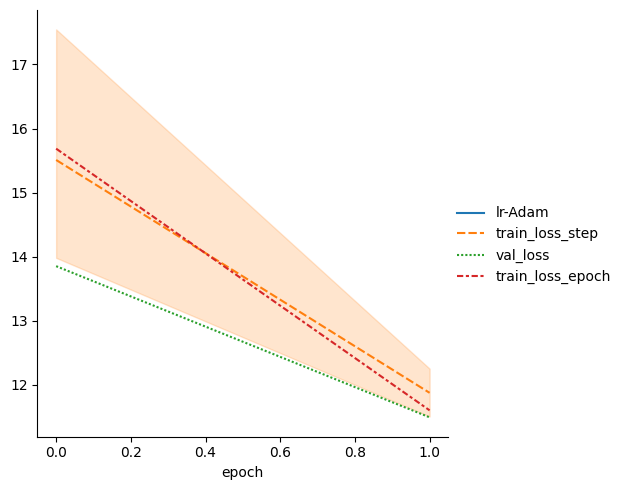

In [17]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [ ]:
trainer.validate(model_yolo)

In [ ]:
model_yolo.load_state_dict(torch.load("model.pth", map_location=torch.device('cpu')), strict=False)

<All keys matched successfully>

In [ ]:
model_yolo

YOLOV3_PL(
  (model): YOLOv3(
    (layers): ModuleList(
      (0): CNNBlock(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky): LeakyReLU(negative_slope=0.1)
      )
      (1): CNNBlock(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky): LeakyReLU(negative_slope=0.1)
      )
      (2): ResidualBlock(
        (layers): ModuleList(
          (0): Sequential(
            (0): CNNBlock(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (leaky): LeakyReLU(negative_slope=0.1)
            )
            (1): CNNBlock(
              (conv): Conv2d(

In [ ]:
trainer.save_checkpoint("best_model.ckpt")